In [2]:
from sar_sim import *
import numpy as np

In [3]:
# Define SAR sensor parameters
sensor = SensorParameters(
    carrier_frequency_hz=360e6,
    bandwidth_hz=50e6,
    pulse_width_s=3e-6,
    PRF_hz=5_000, # To meet the Nyquist criterion, PRF > (4v)/(λ) * sin (grazing_angle)
    sampling_frequency_hz=(360e6+25e6)*2.5,
    sensor_speed_mps=7500.0,
    sensor_height_m=100_000.0,
    grazing_angle_deg=40.0,
    swath_m=5_000.0,
    range_width_m=5_000.0,
    azimuth_resolution_m=2.5,
    integration_angle_rad=calculate_integration_angle(1.2, 3e8/360e6, 2.0)
)

# Define a single point target at an offset
target_pos = (0.0, 0.0, 0.0)


delay: 0.0010419429745525122


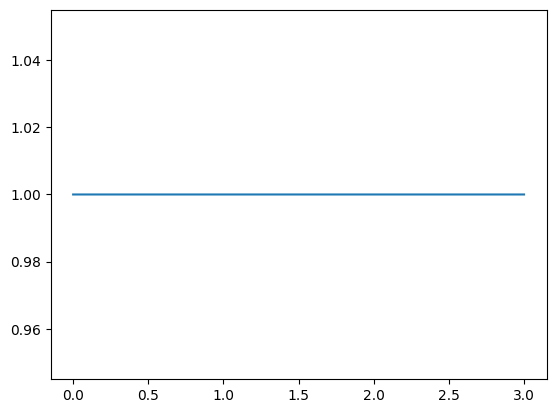

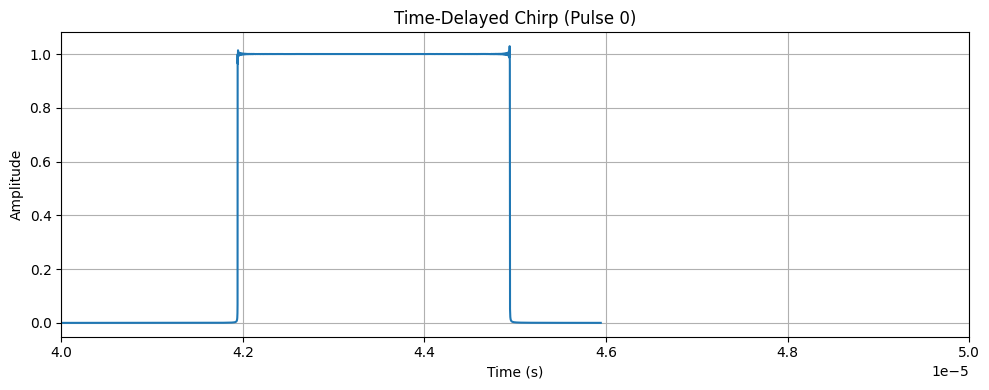

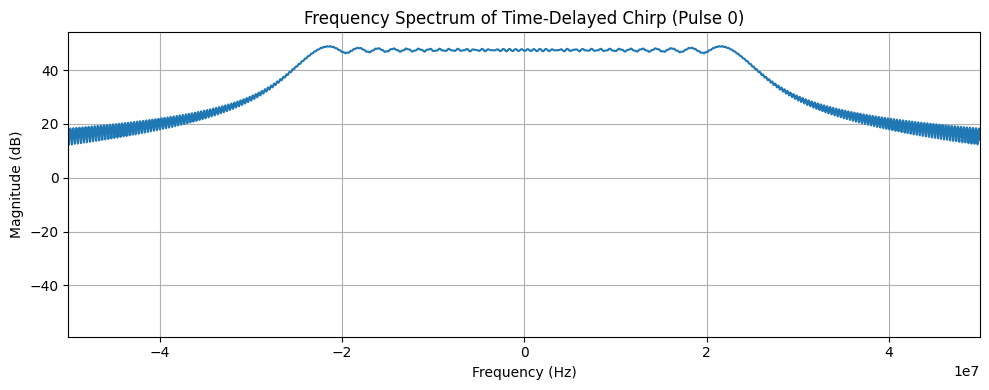

In [4]:
# Simulate raw SAR data
raw_data, time_result, t_start = simulate_raw_data(sensor, target_pos, t_start=1000.0e-6)

# Compute time delays for the target
time_result_target = compute_target_time_delays(sensor, target_pos)

In [4]:
import numpy as np
import plotly.express as px
import plotly.graph_objects as go


def plot_raw_sar_data_interactive(
    raw_data: np.ndarray,
    sampling_frequency_hz: float,
    downsample_fast: int = 10,
    start_time_s: float = 0.0,
    xlim_microseconds: tuple = None,
    title: str = "Simulated Raw SAR Data"
):
    """
    Interactive plot of raw SAR data (Pulse Index vs Fast Time) using Plotly.

    Parameters:
    - raw_data: 2D array [pulses × fast-time]
    - sampling_frequency_hz: Sampling rate in Hz
    - downsample_fast: Downsampling factor in fast-time axis
    - start_time_s: Start time (in seconds) of the fast-time window
    - xlim_microseconds: Optional x-axis limit in µs
    - title: Plot title
    """
    num_pulses, num_fast_time = raw_data.shape
    if downsample_fast <= 0:
        downsample_fast = 1

    # Fast-time axis (downsampled) in microseconds
    fast_time_axis_us = (np.arange(0, num_fast_time, downsample_fast) / sampling_frequency_hz + start_time_s) * 1e6

    # Downsampled amplitude (optional: use dB)
    amp_matrix = np.abs(raw_data[:, ::downsample_fast])

    # Suggest xlim
    energy = np.abs(raw_data).max(axis=0)
    nonzero_indices = np.where(energy > 0.0)[0]

    if len(nonzero_indices) > 0 and xlim_microseconds is None:
        start_us = (nonzero_indices[0] / sampling_frequency_hz + start_time_s) * 1e6
        end_us = (nonzero_indices[-1] / sampling_frequency_hz + start_time_s) * 1e6
        xlim_microseconds = (start_us - 1, end_us + 1)
        print(f"Suggested xlim: ({start_us:.1f} μs, {end_us:.1f} μs)")
    elif xlim_microseconds is None:
        xlim_microseconds = (fast_time_axis_us[0], fast_time_axis_us[-1])

    # Create figure
    fig = go.Figure(data=go.Heatmap(
        z=amp_matrix,
        x=fast_time_axis_us,
        y=np.arange(num_pulses),
        colorscale='Viridis',
        colorbar=dict(title="Amplitude"),
        zsmooth='best'
    ))

    fig.update_layout(
        title=title,
        xaxis_title="Fast Time (μs)",
        yaxis_title="Pulse Index",
        xaxis_range=xlim_microseconds,
        height=600
    )

    fig.show()


In [ ]:
# Plot SAR raw data (Pulse Index vs Fast Time)
plot_raw_sar_data_interactive(raw_data, sensor.sampling_frequency_hz, start_time_s=t_start, xlim_microseconds=(1035, 1050))

In [ ]:
# Check phase vs azimuth
plot_phase_vs_azimuth(raw_data, sensor.sampling_frequency_hz, fast_time_index=0)


In [ ]:
# Plot time delay of the target
plot_slant_range_time_delays(time_result_target)

In [ ]:
plot_chirp_frequency_spectrum(np.fft.ifftshift(raw_data[1]), sensor.sampling_frequency_hz)

## Scenario 1: Simulate range migration then compression

In [ ]:
# Perform range migration alignment
aligned_data = perform_range_migration(
    compressed_data=raw_data,
    sensor=sensor,
    target_position=target_pos,
    reference_signal_frequency_hz=sensor.carrier_frequency_hz,
    sampling_frequency=sensor.sampling_frequency_hz,
    chirp_start_time=t_start
)

In [ ]:
# Plot SAR raw data (Pulse Index vs Fast Time)
plot_raw_sar_data(aligned_data, sensor.sampling_frequency_hz, downsample_fast=10)

In [ ]:
# Perform range compression via matched filtering
compressed_data = simulate_range_compression(aligned_data, sensor)
# Plot the compressed SAR data
plot_raw_sar_data(compressed_data, sensor.sampling_frequency_hz, downsample_fast=10)

In [ ]:
plot_chirp_frequency_spectrum(raw_data[0], sensor.sampling_frequency_hz)

In [ ]:
plot_chirp_frequency_spectrum(compressed_data[0], sensor.sampling_frequency_hz)

In [ ]:
# Check phase vs azimuth
plot_phase_vs_azimuth(aligned_data, sensor.sampling_frequency_hz, fast_time_us=0)

## Scenario 2: Simulate Range Compression then migrate

In [5]:
# Perform range compression via matched filtering
compressed_data = simulate_range_compression(raw_data, sensor)

Suggested xlim: (0.0 μs, 45.9 μs)


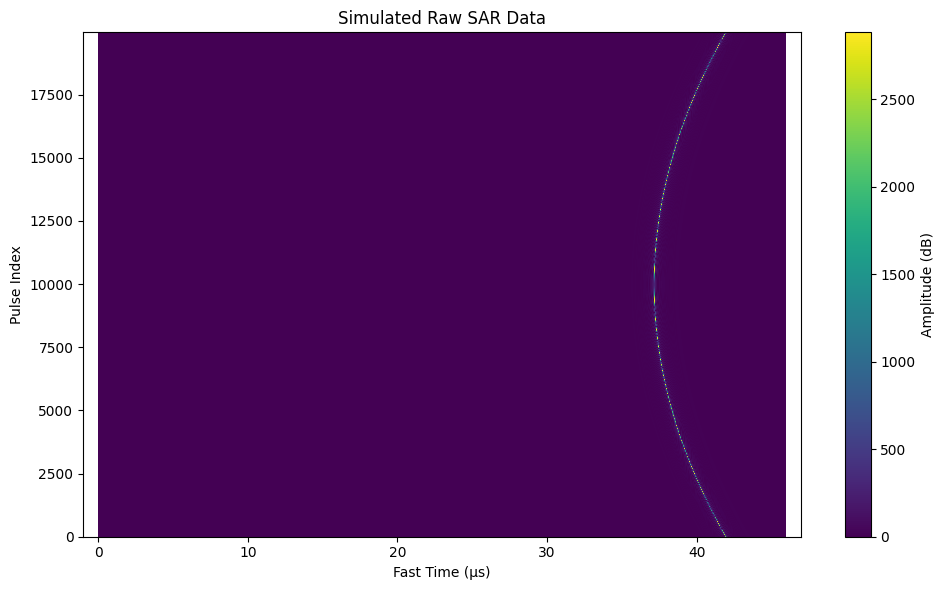

In [6]:
# Plot compressed data
plot_raw_sar_data(compressed_data, sensor.sampling_frequency_hz)

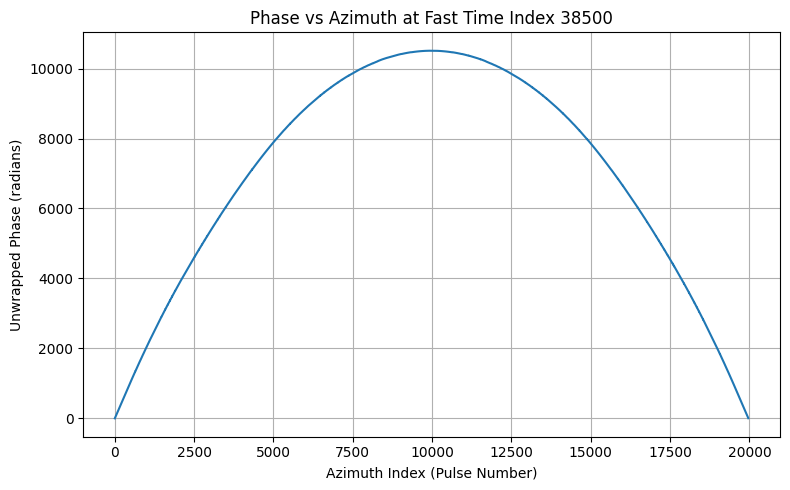

In [7]:
# Check phase vs azimuth
plot_phase_vs_azimuth(compressed_data, sensor.sampling_frequency_hz, fast_time_us=40)

In [8]:
# # Perform range migration alignment
# aligned_data = perform_range_migration(
#     compressed_data=compressed_data,
#     sensor=sensor,
#     target_position=target_pos,
#     reference_signal_frequency_hz=sensor.carrier_frequency_hz,
#     sampling_frequency=sensor.sampling_frequency_hz
# )

# Perform FFT along fast-time axis (axis=1)
compressed_data_fft = np.fft.fft(compressed_data, axis=1)

# Frequency axis
freqs = np.fft.fftfreq(compressed_data.shape[1], d=1 / sensor.sampling_frequency_hz)

# Phase shift matrix: [num_pulses x num_freqs]
phase_shift_matrix = np.exp(+1j * 2 * np.pi * np.outer(time_result_target - t_start, freqs))

# Apply phase shift
aligned_data_fft = compressed_data_fft * phase_shift_matrix

# Inverse FFT to return to time domain
aligned_data = np.fft.ifft(aligned_data_fft, axis=1)



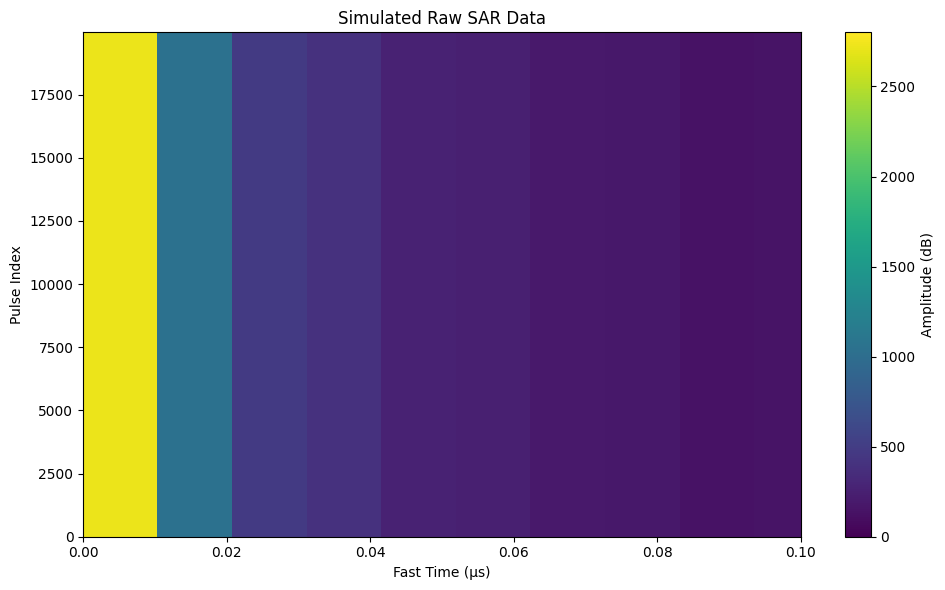

In [9]:
# Plot the aligned data
plot_raw_sar_data(aligned_data, sensor.sampling_frequency_hz, downsample_fast=10, xlim_microseconds=(0, 0.1))

In [10]:
import numpy as np

# Compute magnitude of aligned data
magnitude = np.abs(aligned_data)

# Find global peak index
peak_idx = np.unravel_index(np.argmax(magnitude), magnitude.shape)
az_idx, fast_time_idx = peak_idx

# Convert fast-time index to microseconds
fast_time_us = fast_time_idx / sensor.sampling_frequency_hz * 1e6

print(f"Fast-Time Index = {fast_time_idx} ({fast_time_us:.5f} µs)")



Fast-Time Index = 44217 (45.93974 µs)


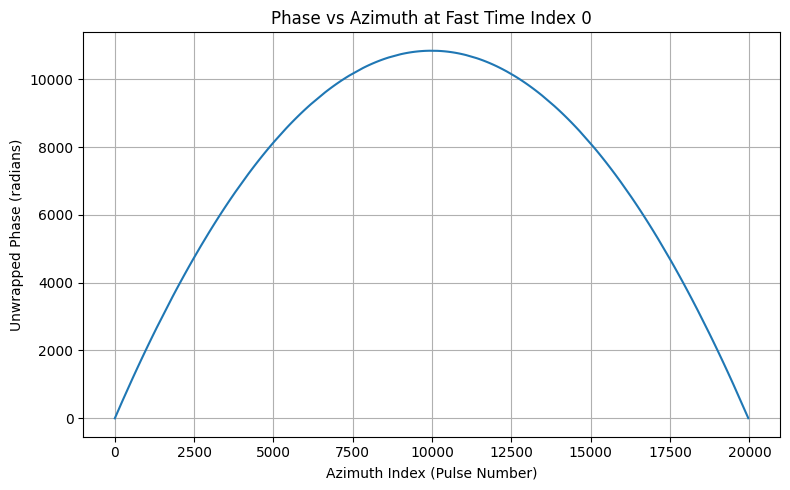

In [11]:
# Check phase vs azimuth
plot_phase_vs_azimuth(aligned_data, sensor.sampling_frequency_hz, fast_time_us=0)

## Perform phase correction in azimuth resolution

In [12]:
# Get shape
num_pulses, num_range_bins = aligned_data.shape

# Generate fast-time vector (range bin times)
fast_time_vector = np.arange(num_range_bins) / sensor.sampling_frequency_hz + t_start  # in seconds

# # Create 2D correction matrix
# # Phase = +2π f_c (τ_n - t), where t varies along range, τ_n along azimuth
# phase_matrix = np.exp(+1j * 2 * np.pi * sensor.carrier_frequency_hz * (
#     time_result_target[:, np.newaxis] - fast_time_vector[np.newaxis, :]
# )).astype(np.complex64)

# # Apply correction across both dimensions
# azimuth_phase_corrected = aligned_data * phase_matrix

In [13]:
azimuth_phase_corrected = np.empty_like(aligned_data, dtype=np.complex64)

for i in range(num_pulses):
    phase_row = np.exp(
        +1j * 2 * np.pi * sensor.carrier_frequency_hz *
        (time_result_target[i] - fast_time_vector)
    ).astype(np.complex64)
    azimuth_phase_corrected[i] = aligned_data[i] * phase_row

In [ ]:
# # Compute azimuth-dependent phase correction term
# phase_correction = np.exp(+1j * 2 * np.pi * sensor.carrier_frequency_hz * (time_result_target-t_start))[:, np.newaxis]
# azimuth_phase_corrected = aligned_data * phase_correction


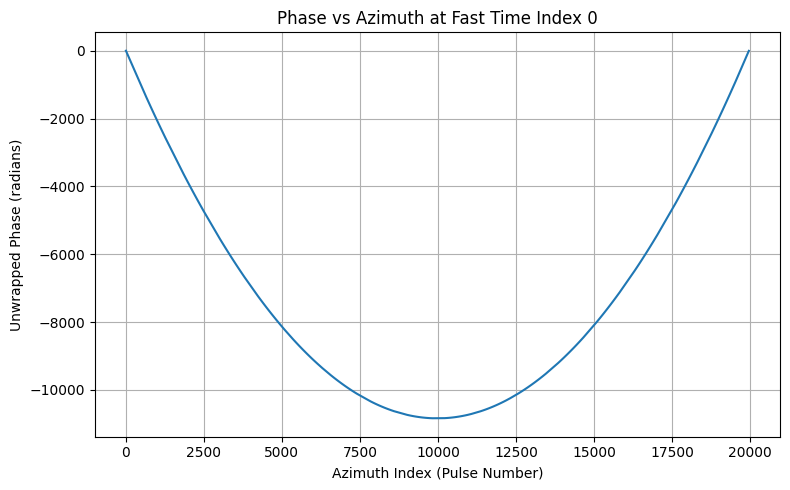

In [ ]:
# Check phase vs azimuth
plot_phase_vs_azimuth(phase_correction, sensor.sampling_frequency_hz, fast_time_us=0)

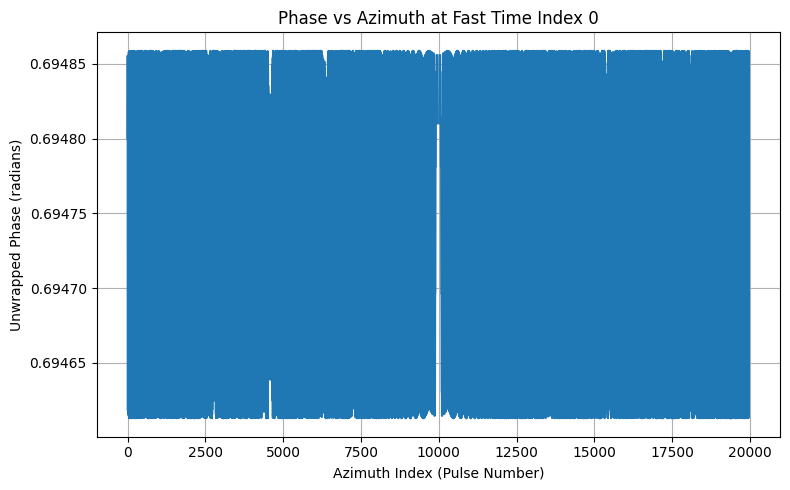

In [ ]:
# Check phase vs azimut h
plot_phase_vs_azimuth(azimuth_phase_corrected, sensor.sampling_frequency_hz, fast_time_us=0)

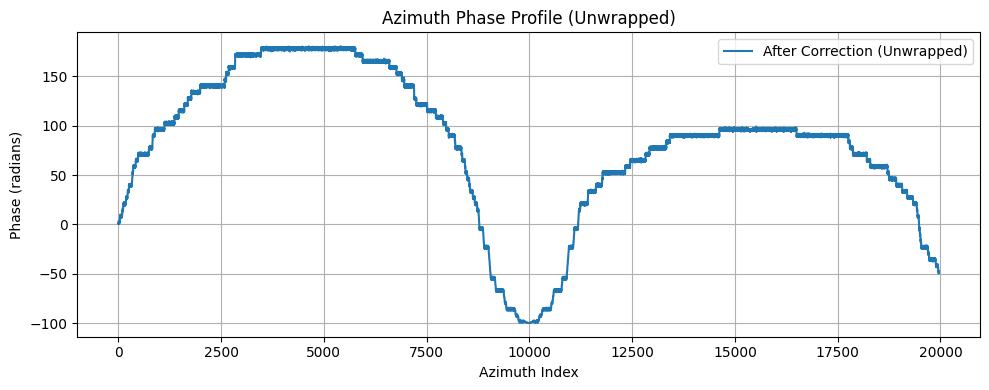

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Choose fast-time index where your peak lies
fast_time_idx = 10358  # Or replace with the actual index of interest

# Raw phases before and after correction
phase_before = np.angle(aligned_data[:, fast_time_idx])
phase_after = np.angle(azimuth_phase_corrected[:, fast_time_idx])

# Apply phase unwrapping across azimuth
phase_before_unwrapped = np.unwrap(phase_before)
phase_after_unwrapped = np.unwrap(phase_after)

# Plot the result
plt.figure(figsize=(10, 4))
# plt.plot(phase_before_unwrapped, label='Before Correction (Unwrapped)')
plt.plot(phase_after_unwrapped, label='After Correction (Unwrapped)')
plt.xlabel('Azimuth Index')
plt.ylabel('Phase (radians)')
plt.title('Azimuth Phase Profile (Unwrapped)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [12]:
import matplotlib.pyplot as plt
plt.plot(np.unwrap(np.angle(phase_correction[:])))
plt.title("Phase Correction Across Azimuth")
plt.xlabel("Azimuth Index")
plt.ylabel("Phase (radians)")
plt.grid(True)
plt.tight_layout()
plt.show()


NameError: name 'phase_correction' is not defined

In [15]:
# Find peak fast_time_us
az_idx, rng_idx = peak_idx  
fast_time_s = rng_idx / sensor.sampling_frequency_hz + t_start  # in seconds
fast_time_us = fast_time_s * 1e6  # convert to microseconds
azimuth_time_s = az_idx / sensor.PRF_hz  # in seconds
azimuth_time_ms = azimuth_time_s * 1e3  # Optional: convert to milliseconds

print(f"fast_time_us = {fast_time_us:.5f} µs, azimuth_time_ms = {azimuth_time_ms:.3f} ms")

fast_time_us = 1045.93974 µs, azimuth_time_ms = 3083.200 ms


In [ ]:
# Check phase vs azimut|h
plot_phase_vs_azimuth(azimuth_phase_corrected, sensor.sampling_frequency_hz, fast_time_us=0)

NameError: name 'azimuth_phase_corrected' is not defined

In [16]:
import numpy as np

def perform_azimuth_compression(
    azimuth_phase_corrected: np.ndarray,
    apply_downsampling: bool = False,
    downsample_factor: int = 2,
    apply_hamming: bool = True
) -> tuple[np.ndarray, tuple[int, int]]:
    """
    Performs memory-efficient azimuth compression with optional downsampling and Hamming window.

    Parameters:
    - azimuth_phase_corrected: 2D complex ndarray [pulses x fast-time]
    - apply_downsampling: whether to downsample in azimuth dimension before compression
    - downsample_factor: factor by which to downsample the azimuth (pulse) dimension
    - apply_hamming: whether to apply a Hamming window before FFT

    Returns:
    - final_image: 2D ndarray [pulses x fast-time], complex64
    - peak_coords: Tuple (az_idx, range_idx) of max amplitude after compression
    """
    # Downsample if needed
    data = azimuth_phase_corrected
    if apply_downsampling:
        data = data[::downsample_factor, :]

    num_pulses, num_range_bins = data.shape
    final_image = np.empty_like(data, dtype=np.complex64)

    # Hamming window (if needed)
    hamming_window = np.hamming(num_pulses).astype(np.float32) if apply_hamming else np.ones(num_pulses, dtype=np.float32)

    # Process one column at a time to save memory
    for rng_idx in range(num_range_bins):
        azimuth_column = data[:, rng_idx] * hamming_window
        final_image[:, rng_idx] = np.fft.ifft(azimuth_column.astype(np.complex64))

    # Peak detection
    peak_idx = np.unravel_index(np.argmax(np.abs(final_image)), final_image.shape)

    return final_image, peak_idx



In [17]:
final_image, (az_idx, range_idx) = perform_azimuth_compression(
    azimuth_phase_corrected,
    apply_downsampling=False,
    apply_hamming=True,
)

print(f"Peak detected at azimuth index = {az_idx}, range index = {range_idx}")


Peak detected at azimuth index = 0, range index = 44217


In [18]:
ifft_shifted_image = np.fft.ifftshift(final_image)

In [19]:
print(np.max(ifft_shifted_image))

(1445.9575+530.7143j)


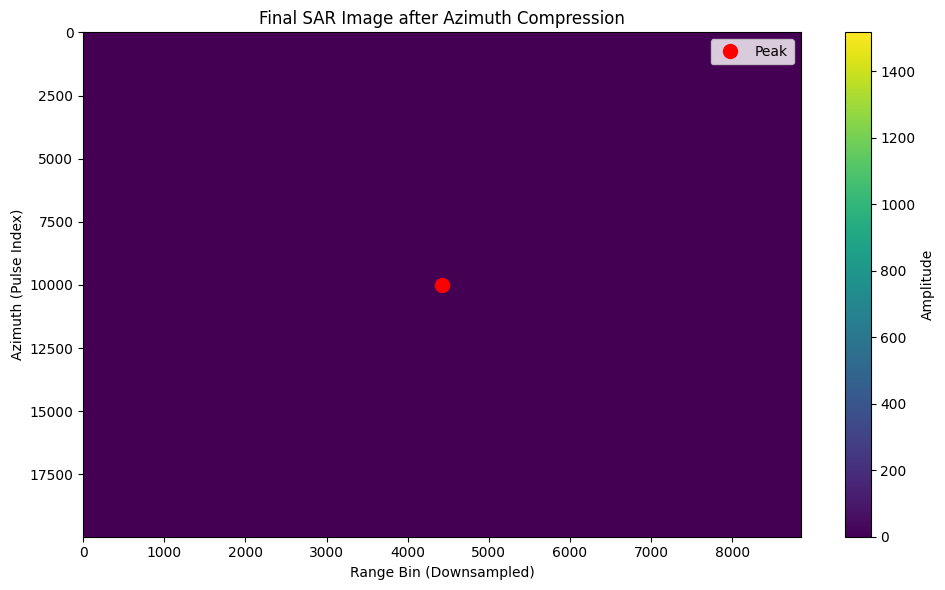

Peak at Azimuth Index = 9983, Range Bin = 22107 (Downsampled index = 4421)


In [33]:
import numpy as np
import matplotlib.pyplot as plt

# Find the peak (maximum amplitude in the image)
peak_idx = np.unravel_index(np.argmax(np.abs(ifft_shifted_image)), ifft_shifted_image.shape)
az_idx, rng_idx = peak_idx  # Row = azimuth index, Col = range index

# Downsample the range index for display
downsample_fast = 5
rng_idx_ds = rng_idx // downsample_fast

# Plot SAR image
plt.figure(figsize=(10, 6))
plt.imshow(
    np.abs(ifft_shifted_image)[:, ::downsample_fast],
    aspect='auto', cmap='viridis'
)
plt.colorbar(label='Amplitude')
plt.xlabel("Range Bin (Downsampled)")
plt.ylabel("Azimuth (Pulse Index)")
plt.title("Final SAR Image after Azimuth Compression")
# plt.xlim(4400, 4500)
# plt.ylim(9900,10000)

# Mark the peak with a large red dot
plt.plot(rng_idx_ds, az_idx, 'ro', markersize=10, label='Peak')  # Increase size here
plt.legend()

plt.tight_layout()
plt.show()

# Print peak location
print(f"Peak at Azimuth Index = {az_idx}, Range Bin = {rng_idx} (Downsampled index = {rng_idx_ds})")


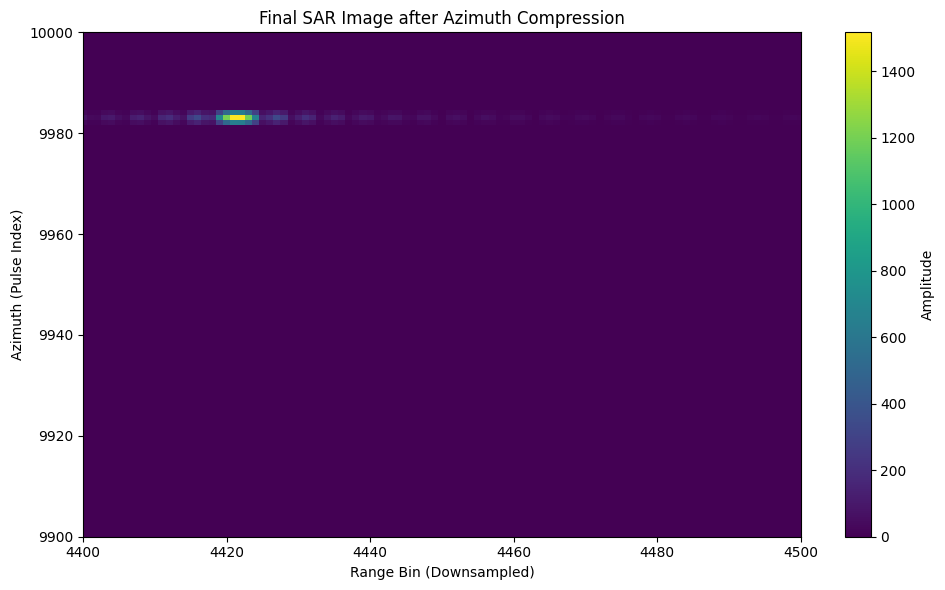

Peak at Azimuth Index = 9983, Range Bin = 22107 (Downsampled index = 4421)


In [34]:
import numpy as np
import matplotlib.pyplot as plt

# Find the peak (maximum amplitude in the image)
peak_idx = np.unravel_index(np.argmax(np.abs(ifft_shifted_image)), ifft_shifted_image.shape)
az_idx, rng_idx = peak_idx  # Row = azimuth index, Col = range index

# Downsample the range index for display
downsample_fast = 5
rng_idx_ds = rng_idx // downsample_fast

# Plot SAR image without the peak marker
plt.figure(figsize=(10, 6))
plt.imshow(
    np.abs(ifft_shifted_image)[:, ::downsample_fast],
    aspect='auto', cmap='viridis'
)
plt.colorbar(label='Amplitude')
plt.xlabel("Range Bin (Downsampled)")
plt.ylabel("Azimuth (Pulse Index)")
plt.title("Final SAR Image after Azimuth Compression")
plt.xlim(4400, 4500)
plt.ylim(9900,10000)

plt.tight_layout()
plt.show()

# Print peak location
print(f"Peak at Azimuth Index = {az_idx}, Range Bin = {rng_idx} (Downsampled index = {rng_idx_ds})")


In [42]:
import numpy as np
import plotly.graph_objects as go

# Define pulse index to inspect
pulse_index = az_idx  # or manually set, e.g. pulse_index = 9999

# Extract that azimuth line
line = ifft_shifted_image[pulse_index, :]

# Convert to dB
line_db = 20 * np.log10(np.abs(line) + 1e-12)

# Compute fast time axis in microseconds
fast_time_vector_us = (np.arange(len(line)) / sensor.sampling_frequency_hz + t_start) * 1e6

# Create interactive plot
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=fast_time_vector_us,
    y=line_db,
    mode='lines',
    name=f'Azimuth Index {pulse_index}'
))

# Customise layout
fig.update_layout(
    title=f'Azimuth Index {pulse_index} — Signal vs Fast Time (Interactive)',
    xaxis_title='Fast Time (μs)',
    yaxis_title='Amplitude (dB)',
    xaxis=dict(range=[1022.75, 1023.25]),
    hovermode='x unified',
    height=500
)

fig.show()

